In [52]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Input, Activation, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import Adam

In [25]:
data_1d = pd.read_csv("./data/data", index_col=0)
data_5m = pd.read_csv("./data/data_5m", index_col=0)

In [4]:
print("Tesla Data One Day")
data_1d.head(5)

Tesla Data One Day


,Adj Close,High,Low,Open,RSI,EMAF,EMAM,VWAP,ATR,BB_Upper,BB_Middle,BB_Lower,Buy_Signal,Sell_Signal
0,1.393333,1.396667,1.373333,1.377333,56.715667,1.356077,1.322240,1.387778,0.058878,1.420931,1.386666,1.352402,False,False
1,1.380667,1.403333,1.379333,1.400000,55.066528,1.360548,1.324531,1.387778,0.056324,1.416951,1.390133,1.363315,False,False
2,1.344667,1.395333,1.317333,1.383333,50.566024,1.357660,1.325321,1.352444,0.057908,1.418959,1.378267,1.337574,False,False
3,1.381333,1.393333,1.366667,1.392667,54.632896,1.361965,1.327517,1.380444,0.057234,1.406780,1.373867,1.340953,False,False
4,1.408000,1.440000,1.368667,1.369333,57.379217,1.370335,1.330674,1.405556,0.058261,1.423549,1.381600,1.339651,False,False


In [5]:
print("Tesla Data Five Minute")
data_5m.head(5)

Tesla Data Five Minute


,Adj Close,High,Low,Open,RSI,EMAF,EMAM,VWAP,ATR,BB_Upper,BB_Middle,BB_Lower,Buy_Signal,Sell_Signal
0,257.470001,258.329987,257.269989,258.050690,27.282916,257.850519,259.681408,260.903462,1.298277,265.520734,260.609145,255.697555,False,False
1,258.630005,258.750000,257.239990,257.489990,38.794431,258.110348,259.549983,260.831331,1.329977,265.341254,260.424146,255.507037,False,False
2,258.614990,259.260010,258.399994,258.669891,38.709013,258.278562,259.433109,260.779689,1.260095,265.109731,260.229645,255.349558,False,False
3,258.654388,259.189911,258.555389,258.555389,39.088004,258.403837,259.335769,260.741256,1.167614,264.545475,259.958115,255.370754,False,False
4,259.489990,259.679993,258.644989,258.644989,46.626196,258.765888,259.355046,260.701962,1.148107,264.074659,259.763364,255.452068,False,False


In [6]:
# Function to merge Buy and Sell signals into a single Signal column
def combine_signals(df):
    df['Signal'] = 0  # Default value for no signal
    df.loc[df['Buy_Signal'] == True, 'Signal'] = 1
    df.loc[df['Sell_Signal'] == True, 'Signal'] = -1
    return df.drop(columns=['Buy_Signal', 'Sell_Signal'])

# Apply the function to both datasets
data_1d = combine_signals(data_1d)
data_5m = combine_signals(data_5m)

# Display the first few rows of the processed data for validation
data_1d.head(), data_5m.head()


(   Adj Close      High       Low      Open        RSI      EMAF      EMAM  \
 0   1.393333  1.396667  1.373333  1.377333  56.715667  1.356077  1.322240   
 1   1.380667  1.403333  1.379333  1.400000  55.066528  1.360548  1.324531   
 2   1.344667  1.395333  1.317333  1.383333  50.566024  1.357660  1.325321   
 3   1.381333  1.393333  1.366667  1.392667  54.632896  1.361965  1.327517   
 4   1.408000  1.440000  1.368667  1.369333  57.379217  1.370335  1.330674   
 
        VWAP       ATR  BB_Upper  BB_Middle  BB_Lower  Signal  
 0  1.387778  0.058878  1.420931   1.386666  1.352402       0  
 1  1.387778  0.056324  1.416951   1.390133  1.363315       0  
 2  1.352444  0.057908  1.418959   1.378267  1.337574       0  
 3  1.380444  0.057234  1.406780   1.373867  1.340953       0  
 4  1.405556  0.058261  1.423549   1.381600  1.339651       0  ,
     Adj Close        High         Low        Open        RSI        EMAF  \
 0  257.470001  258.329987  257.269989  258.050690  27.282916  257.8

In [7]:
# Combine the datasets
data = pd.concat([data_1d, data_5m], ignore_index=True)

# Ensure the 'Signal' column is properly formatted as integer (if not already)
data['Signal'] = data['Signal'].astype(int)

In [8]:
data

,Adj Close,High,Low,Open,RSI,EMAF,EMAM,VWAP,ATR,BB_Upper,BB_Middle,BB_Lower,Signal
0,1.393333,1.396667,1.373333,1.377333,56.715667,1.356077,1.322240,1.387778,0.058878,1.420931,1.386666,1.352402,0
1,1.380667,1.403333,1.379333,1.400000,55.066528,1.360548,1.324531,1.387778,0.056324,1.416951,1.390133,1.363315,0
2,1.344667,1.395333,1.317333,1.383333,50.566024,1.357660,1.325321,1.352444,0.057908,1.418959,1.378267,1.337574,0
3,1.381333,1.393333,1.366667,1.392667,54.632896,1.361965,1.327517,1.380444,0.057234,1.406780,1.373867,1.340953,0
4,1.408000,1.440000,1.368667,1.369333,57.379217,1.370335,1.330674,1.405556,0.058261,1.423549,1.381600,1.339651,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6804,336.720001,336.849915,335.660004,336.434998,33.857885,337.290947,338.245337,341.817519,1.216976,340.496935,338.424174,336.351414,0
6805,336.950012,337.043396,336.320007,336.690002,35.781464,337.177302,338.083421,341.779996,1.146463,340.097106,338.232750,336.368394,0
6806,338.160004,338.289886,336.899994,336.950104,44.865411,337.504869,338.092994,341.736575,1.181239,339.731794,338.125896,336.519997,0
6807,337.769989,338.299988,337.200104,338.200012,42.765546,337.593243,338.052618,341.684911,1.169617,339.566324,338.049084,336.531845,0


In [9]:
sc = MinMaxScaler(feature_range=(0,1))
data_scaled = sc.fit_transform(data)
print(data_scaled)
print(data_scaled.shape)

[[2.18596453e-04 1.30701915e-04 1.81352799e-04 ... 1.05204579e-04
  2.26383234e-04 5.00000000e-01]
 [1.87602959e-04 1.46836202e-04 1.96190921e-04 ... 1.13833770e-04
  2.54473841e-04 5.00000000e-01]
 [9.95114292e-05 1.27473212e-04 4.28646389e-05 ... 8.42966190e-05
  1.88216506e-04 5.00000000e-01]
 ...
 [8.24281938e-01 8.15548716e-01 8.29939829e-01 ... 8.38281506e-01
  8.62958125e-01 5.00000000e-01]
 [8.23327578e-01 8.15573165e-01 8.30682002e-01 ... 8.38090315e-01
  8.62988622e-01 5.00000000e-01]
 [8.24502158e-01 8.16299331e-01 8.32140838e-01 ... 8.38061343e-01
  8.62984269e-01 5.00000000e-01]]
(6809, 13)


In [27]:
# Parameters
backcandles = 30  # Number of previous time steps to include
num_features = 12  # Number of features to use from the dataset

# Assuming data_set_scaled is a NumPy array with shape (samples, features)
# Ensure it has at least `num_features` columns
X = np.array([data_scaled[i - backcandles:i, :num_features] 
              for i in range(backcandles, data_scaled.shape[0])])

# Prepare the target (y) from the last column (-1)
y = data_scaled[backcandles:, 1].reshape(-1, 1)

# Print shapes
print("X shape:", X.shape)  # Expected: (samples, backcandles, num_features)
print("y shape:", y.shape)  # Expected: (samples, 1)


X shape: (6779, 30, 12)
y shape: (6779, 1)


In [28]:
# split data into train test sets
splitlimit = int(len(X)*0.8)
print(splitlimit)
X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(y_train)

5423
(5423, 30, 12)
(1356, 30, 12)
(5423, 1)
(1356, 1)
[[8.87466540e-05]
 [1.30701915e-04]
 [1.27473212e-04]
 ...
 [5.96720191e-01]
 [5.97978775e-01]
 [5.98656486e-01]]


In [53]:
# Model architecture
lstm_input = Input(shape=(backcandles, num_features), name='lstm_input')

# LSTM layers
x = LSTM(150, return_sequences=True, name='lstm_layer_1')(lstm_input)
x = Dropout(0.3)(x)
x = LSTM(100, name='lstm_layer_2')(x)
x = BatchNormalization()(x)

# Dense layers
x = Dense(50, activation='relu', name='dense_layer_1')(x)
x = Dropout(0.2)(x)
x = Dense(20, activation='relu', name='dense_layer_2')(x)
x = Dense(3, activation='softmax', name='output_layer')(x)  # 3 classes: Buy, Sell, No Signal

# Compile the model
model = Model(inputs=lstm_input, outputs=x)
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Print model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_input (InputLayer)         │ (None, 30, 12)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_layer_1 (LSTM)             │ (None, 30, 150)        │        97,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 150)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_layer_2 (LSTM)             │ (None, 100)            │       100,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_layer_1 (Dense)           │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_layer_2 (Dense)           │ (None, 20)             │         1,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 3)              │            63 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 204,733 (799.74 KB)

 Trainable params: 204,533 (798.96 KB)

 Non-trainable params: 200 (800.00 B)

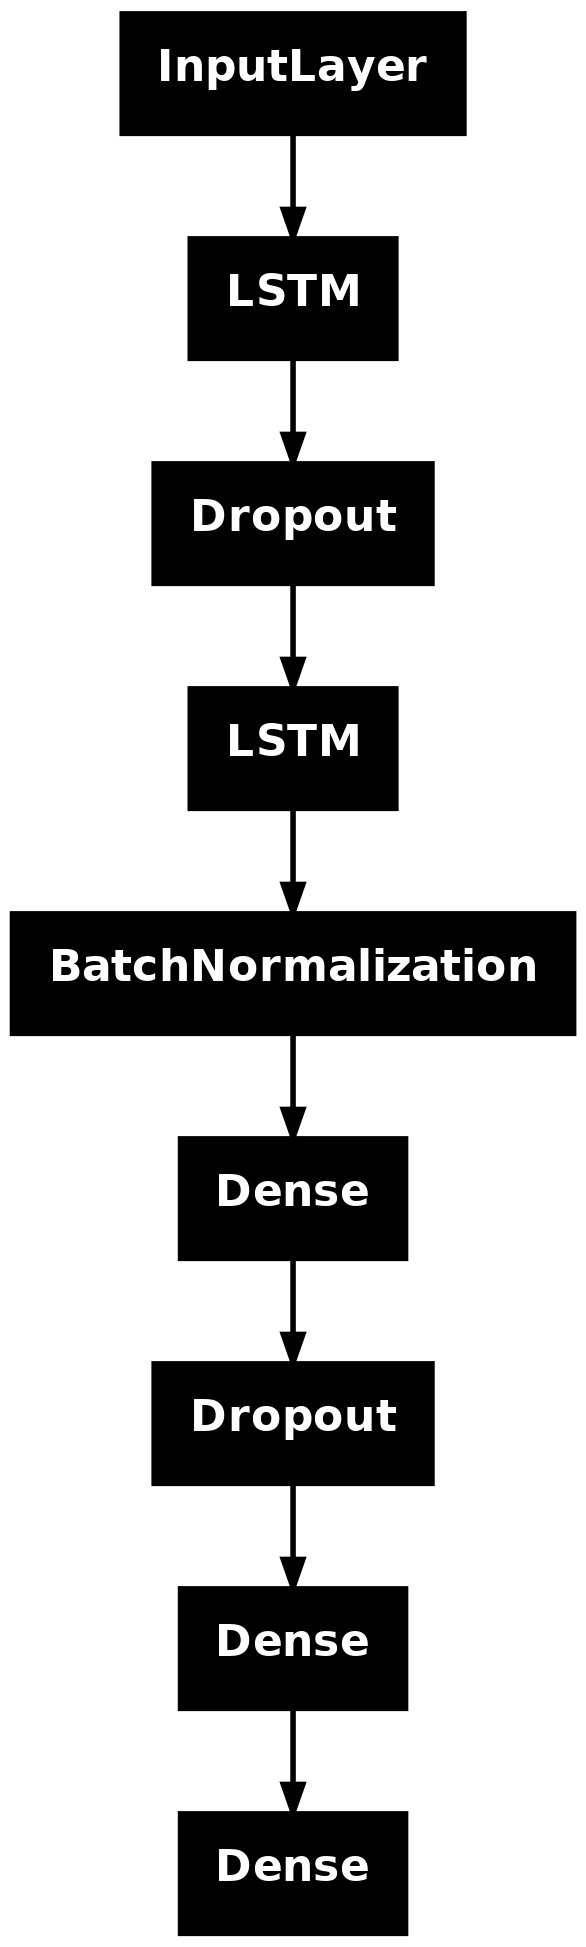

In [54]:
plot_model(model)

In [26]:
# Train the model
history = model.fit(
    x=X_train, 
    y=y_train,
    validation_split=0.1,
    epochs=50,
    batch_size=32,
    shuffle=True,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.0377 - loss: 0.2317 - val_accuracy: 0.0350 - val_loss: 0.1947 - learning_rate: 0.0010
Epoch 2/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.0365 - loss: 0.1700 - val_accuracy: 0.0350 - val_loss: 0.1722 - learning_rate: 0.0010
Epoch 3/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.0429 - loss: 0.1624 - val_accuracy: 0.0350 - val_loss: 0.1488 - learning_rate: 0.0010
Epoch 4/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.0413 - loss: 0.1535 - val_accuracy: 0.0350 - val_loss: 0.1677 - learning_rate: 0.0010
Epoch 5/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.0396 - loss: 0.1430 - val_accuracy: 0.0350 - val_loss: 0.2161 - learning_rate: 0.0010
Epoch 6/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.0418 - loss: 0.1459 - val_accuracy: 0.0350 - val_loss: 0.1527 - learning_rate: 0.0010
Epoch 7/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.0450 - loss: 0.

In [27]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss: 0.11400214582681656
Test Accuracy: 0.033923305571079254


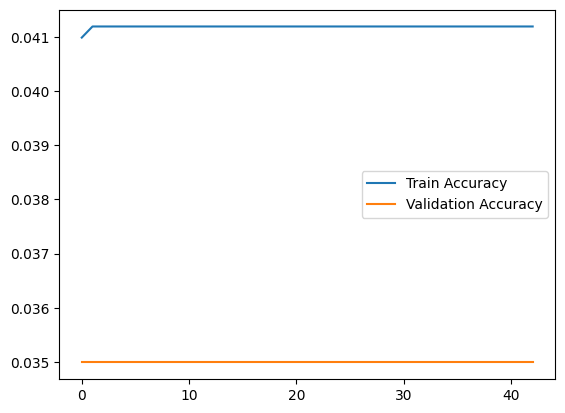

In [28]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()


In [31]:
model2 = Sequential()
model2.add(LSTM(64, return_sequences=False))
model2.add(Dense(32, activation='relu'))
model2.add(Dense(3, activation='softmax'))

optimizer = Adam(learning_rate=0.001)
model2.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [32]:
# Train the model
history2 = model2.fit(
    x=X_train, 
    y=y_train,
    validation_split=0.1,
    epochs=50,
    batch_size=32,
    # shuffle=True
    # callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.0370 - loss: 0.3690 - val_accuracy: 0.0350 - val_loss: 0.1546
Epoch 2/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.0436 - loss: 0.1634 - val_accuracy: 0.0350 - val_loss: 0.1517
Epoch 3/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.0450 - loss: 0.1580 - val_accuracy: 0.0350 - val_loss: 0.1517
Epoch 4/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.0404 - loss: 0.1490 - val_accuracy: 0.0350 - val_loss: 0.1534
Epoch 5/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.0417 - loss: 0.1578 - val_accuracy: 0.0350 - val_loss: 0.1517
Epoch 6/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.0376 - loss: 0.1504 - val_accuracy: 0.0350 - val_loss: 0.1522
Epoch 7/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.0448 - loss: 0.1532 - val_accuracy: 0.0350 - val_loss: 0.1518
Epoch 8/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.0415 - loss: 0.1569 - val_accu

In [33]:
# Evaluate the model
test_loss, test_accuracy = model2.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss: 0.13987082242965698
Test Accuracy: 0.033923305571079254


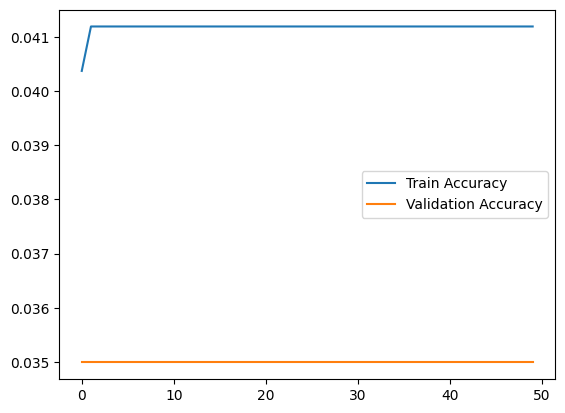

In [34]:
plt.plot(history2.history['accuracy'], label='Train Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()


In [36]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    'balanced', classes=np.unique(y_train), y=y_train.flatten()
)
class_weights = dict(enumerate(class_weights))

model2.fit(X_train, y_train, class_weight=class_weights, epochs=50)


Epoch 1/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.0384 - loss: 0.1162
Epoch 2/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.0411 - loss: 0.0801
Epoch 3/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.0411 - loss: 0.0664
Epoch 4/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.0438 - loss: 0.0789
Epoch 5/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.0434 - loss: 0.0766
Epoch 6/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.0344 - loss: 0.0733
Epoch 7/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.0435 - loss: 0.0716
Epoch 8/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.0446 - loss: 0.0749
Epoch 9/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.0386 - loss: 0.0708
Epoch 10/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.0411 - loss: 0.0715
Epoch 11/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.0447 - loss: 0.0773
Epoch 12/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 

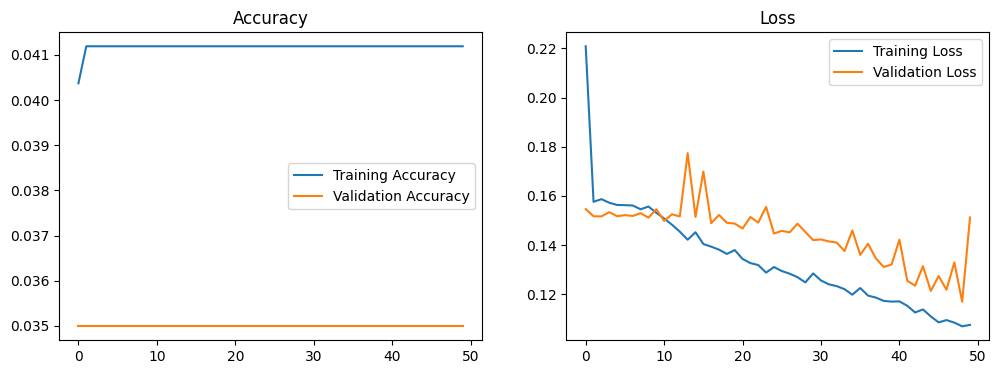

In [37]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()


# N-BEATS
---

## Model 7: N-BEATS Algorithm

So far, we've experimented with several smaller models, each consisting of only a few layers. However, one effective strategy to enhance a model's performance is to increase its depth by adding more layers.

This is precisely what the [N-BEATS (Neural Basis Expansion Analysis for Interpretable Time Series Forecasting) algorithm](https://arxiv.org/pdf/1905.10437.pdf) achieves. Designed for univariate time series problems, N-BEATS gained recognition by achieving state-of-the-art performance and winning the prestigious [M4 competition](https://www.sciencedirect.com/science/article/pii/S0169207019301128), a global forecasting competition.

For our next modeling experiment, we will replicate the **generic architecture** of the N-BEATS algorithm, as outlined in [section 3.3 of the N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf). 

Rather than delving into all the technical details in the paper, we will focus on two main aspects:
1. Replicating the model architecture depicted in [Figure 1 of the N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf).

   ![figure 1 from N-BEATS paper, the algorithm we're going to build](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-figure-1-nbeats-paper-annotated.png)
   *Annotated diagram of the N-BEATS algorithm with window (input) and horizon (output) explanations.*

2. Using the same hyperparameters specified in the paper, which are detailed in [Appendix D of the N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf).

This exercise provides a great opportunity to:
* Develop a custom layer for the `NBeatsBlock` by subclassing the [`tf.keras.layers.Layer`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer) class.
  * Creating a custom layer is useful for scenarios where TensorFlow lacks a built-in implementation or when you want to repeat a specific configuration multiple times (e.g., stacking N-BEATS blocks).
* Design a custom model architecture using the Functional API.
* Explore and implement a research paper relevant to our problem, testing its effectiveness.


In [20]:
data_1d, data_5m

(       Adj Close        High         Low        Open        RSI        EMAF  \
 0       1.393333    1.396667    1.373333    1.377333  56.715667    1.356077   
 1       1.380667    1.403333    1.379333    1.400000  55.066528    1.360548   
 2       1.344667    1.395333    1.317333    1.383333  50.566024    1.357660   
 3       1.381333    1.393333    1.366667    1.392667  54.632896    1.361965   
 4       1.408000    1.440000    1.368667    1.369333  57.379217    1.370335   
 ...          ...         ...         ...         ...        ...         ...   
 3547  217.800003  223.339996  214.380005  220.130005  38.693197  239.715986   
 3548  219.160004  221.910004  213.740005  220.130005  39.620187  235.978535   
 3549  219.570007  224.259995  217.119995  220.009995  39.915148  232.995166   
 3550  221.330002  222.820007  218.929993  221.399994  41.242077  230.874227   
 3551  220.889999  222.080002  217.899994  221.589996  40.998309  229.058913   
 
             EMAM        VWAP        A

In [22]:
# Combine the datasets
data_nb = pd.concat([data_1d, data_5m], ignore_index=True)

In [23]:
data_nb

,Adj Close,High,Low,Open,RSI,EMAF,EMAM,VWAP,ATR,BB_Upper,BB_Middle,BB_Lower,Signal
0,1.393333,1.396667,1.373333,1.377333,56.715667,1.356077,1.322240,1.387778,0.058878,1.420931,1.386666,1.352402,0
1,1.380667,1.403333,1.379333,1.400000,55.066528,1.360548,1.324531,1.387778,0.056324,1.416951,1.390133,1.363315,0
2,1.344667,1.395333,1.317333,1.383333,50.566024,1.357660,1.325321,1.352444,0.057908,1.418959,1.378267,1.337574,0
3,1.381333,1.393333,1.366667,1.392667,54.632896,1.361965,1.327517,1.380444,0.057234,1.406780,1.373867,1.340953,0
4,1.408000,1.440000,1.368667,1.369333,57.379217,1.370335,1.330674,1.405556,0.058261,1.423549,1.381600,1.339651,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6804,336.720001,336.849915,335.660004,336.434998,33.857885,337.290947,338.245337,341.817519,1.216976,340.496935,338.424174,336.351414,0
6805,336.950012,337.043396,336.320007,336.690002,35.781464,337.177302,338.083421,341.779996,1.146463,340.097106,338.232750,336.368394,0
6806,338.160004,338.289886,336.899994,336.950104,44.865411,337.504869,338.092994,341.736575,1.181239,339.731794,338.125896,336.519997,0
6807,337.769989,338.299988,337.200104,338.200012,42.765546,337.593243,338.052618,341.684911,1.169617,339.566324,338.049084,336.531845,0


In [29]:
X_train

array([[[2.18596453e-04, 1.30701915e-04, 1.81352799e-04, ...,
         1.14612662e-04, 1.05204579e-04, 2.26383234e-04],
        [1.87602959e-04, 1.46836202e-04, 1.96190921e-04, ...,
         1.05572402e-04, 1.13833770e-04, 2.54473841e-04],
        [9.95114292e-05, 1.27473212e-04, 4.28646389e-05, ...,
         1.10132772e-04, 8.42966190e-05, 1.88216506e-04],
        ...,
        [1.59868960e-04, 1.22632175e-04, 1.23650332e-04, ...,
         4.51983092e-05, 4.91168580e-05, 1.89031952e-04],
        [1.09299539e-04, 8.06795108e-05, 1.18704390e-04, ...,
         4.55866413e-05, 4.87852993e-05, 1.87906197e-04],
        [7.99355012e-05, 4.35673051e-05, 8.24327688e-05, ...,
         5.50285166e-05, 4.24798682e-05, 1.64166633e-04]],

       [[1.87602959e-04, 1.46836202e-04, 1.96190921e-04, ...,
         1.05572402e-04, 1.13833770e-04, 2.54473841e-04],
        [9.95114292e-05, 1.27473212e-04, 4.28646389e-05, ...,
         1.10132772e-04, 8.42966190e-05, 1.88216506e-04],
        [1.89232707e-04, 

In [30]:
y_train

array([[8.87466540e-05],
       [1.30701915e-04],
       [1.27473212e-04],
       ...,
       [5.96720191e-01],
       [5.97978775e-01],
       [5.98656486e-01]])

In [31]:
# Setup dataset hyperparameters
HORIZON = 1
WINDOW_SIZE = 30

In [32]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=1):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1 (default)
  Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [33]:
# Create function to view NumPy arrays as windows 
def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  # print(f"Window step:\n {window_step}")

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  # print(f"Window indexes:\n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [34]:
# Create NBeatsBlock custom layer 
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, # the constructor takes all the hyperparameters for the layer
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): # the **kwargs argument takes care of all of the arguments for the parent class (input_shape, trainable, name)
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs): # the call method is what runs when the layer is called 
    x = inputs 
    for layer in self.hidden: # pass inputs through each hidden layer 
      x = layer(x)
    theta = self.theta_layer(x) 
    # Output the backcast and forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

In [16]:
# Set up dummy NBeatsBlock layer to represent inputs and outputs
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE, 
                                       theta_size=WINDOW_SIZE+HORIZON, # backcast + forecast 
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)

In [36]:
# Create dummy inputs (have to be same size as input_size)
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) + 1, axis=0) # input shape to the model has to reflect Dense layer input requirements (ndim=2)
dummy_inputs

<tf.Tensor: shape=(1, 30), dtype=int32, numpy=
array([[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]],
      dtype=int32)>

In [37]:
# 1. Turn train and test arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# 2. Combine features & labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 30, 12), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 30, 12), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>)

In [47]:
# Values from N-BEATS paper Figure 1 and Table 18/Appendix D
N_EPOCHS = 5 # called "Iterations" in Table 18
N_NEURONS = 512 # called "Width" in Table 18
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON # called "Lookback" in Table 18
THETA_SIZE = 12

INPUT_SIZE, THETA_SIZE

(30, 12)

In [48]:
# Make tensors
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

# Subtract
subtracted = layers.subtract([tensor_1, tensor_2])

# Add
added = layers.add([tensor_1, tensor_2])

print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")

Input tensors: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]


Both of these layer functions are straight-forward, subtract or add together their inputs.

And as mentioned before, they're what powers N-BEATS double residual stacking.

The power of **residual stacking** or **residual connections** was revealed in [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385) where the authors were able to build a deeper but less complex neural network (this is what introduced the popular [ResNet architecture](https://en.wikipedia.org/wiki/Residual_neural_network)) than previous attempts. 

This deeper neural network led to state of the art results on the ImageNet challenge in 2015 and different versions of residual connections have been present in deep learning ever since.

> What is a residual connection?

A **residual connection** (also called skip connections) involves a deeper neural network layer receiving the outputs as well as the inputs of a shallower neural network layer.

In the case of N-BEATS, the architecture uses residual connections which:
* Subtract the backcast outputs from a previous block from the backcast inputs to the current block
* Add the forecast outputs from all blocks together in a stack 

![N-BEATS architecture double residual stacking](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-nbeats-architecture-double-residual-stacking.png)
*Annotated version of Figure 1 from the N-BEATS paper highlighting the double residual stacking (section 3.2) of the architecture. Backcast residuals of each block are subtracted from each other and used as the input to the next block where as the forecasts of each block are added together to become the stack forecast.*

> What are the benefits of residual connections?

In practice, residual connections have been beneficial for training deeper models (N-BEATS reaches ~150 layers, also see "These approaches provide clear advantages in improving the trainability of deep architectures" in section 3.2 of the [N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf)).  

It's thought that they help avoid the problem of [vanishing gradients](https://en.wikipedia.org/wiki/Vanishing_gradient_problem) (patterns learned by a neural network not being passed through to deeper layers).



In [49]:
 %%time

tf.random.set_seed(42)

# 1. Setup N-BEATS Block layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# 2. Create input to stacks
stack_input = layers.Input(shape=(INPUT_SIZE, 12), name="stack_input")

# 3. Create initial backcast and forecast input (backwards predictions are referred to as residuals in the paper)
backcast, forecast = nbeats_block_layer(stack_input)
# Add in subtraction residual link, thank you to: https://github.com/mrdbourke/tensorflow-deep-learning/discussions/174 
residuals = layers.subtract([stack_input, backcast], name=f"subtract_00") 

# 4. Create stacks of blocks
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already creted in (3)

  # 5. Use the NBeatsBlock to calculate the backcast as well as block forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass it in residuals (the backcast)

  # 6. Create the double residual stacking
  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}") 
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model_7 = tf.keras.Model(inputs=stack_input, 
                         outputs=forecast, 
                         name="model_7_N-BEATS")

# 8. Compile with MAE loss and Adam optimizer
model_7.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model_7.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0, # prevent large amounts of training outputs
            # callbacks=[create_model_checkpoint(model_name=stack_model.name)] # saving model every epoch consumes far too much time
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])

I0000 00:00:1733263411.852293     355 service.cc:146] XLA service 0x7f22cc002df0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733263411.852363     355 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2024-12-03 22:03:32.748352: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-03 22:03:36.171128: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8906
2024-12-03 22:03:38.823839: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_603', 4 bytes spill stores, 4 bytes spill loads

2024-12-03 22:03:39.084862: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory i

ResourceExhaustedError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.11/dist-packages/ipykernel_launcher.py", line 18, in <module>

  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 739, in start

  File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 604, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_112/992911748.py", line 1, in <module>

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2541, in run_cell_magic

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/magics/execution.py", line 1345, in time

  File "<timed exec>", line 47, in <module>

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 318, in fit

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

Out of memory while trying to allocate 7720206960 bytes.
	 [[{{node StatefulPartitionedCall}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_one_step_on_iterator_64936]

In [ ]:
# Evaluate N-BEATS model on the test dataset
model_7.evaluate(test_dataset)

1/1 [==============================] - 0s 46ms/step - loss: 585.4998 - mae: 585.4998 - mse: 1179491.5000


[585.4998168945312, 585.4998168945312, 1179491.5]

In [55]:
# Plot the N-BEATS model and inspect the architecture
from tensorflow.keras.utils import plot_model
plot_model(model_7)